# Benchmark Problem Series J 
Benchmark notebook to compare implemented methods to the example from Box, G.E.P., Jenkins, G.M., Reinsel G.C., & Greta M. Ljung (2016). Time series analysis: forecasting and control. Fifth edition. John Wiley & Sons, Inc.

# Packages

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf

import pastas_plugins.crosscorrelation as ppcc


def plot_corr(
    corr: pd.Series | pd.DataFrame,
    ax: plt.Axes | None = None,
    vlines_kwargs: dict | None = None,
):
    """Helper function for the statsmodels _plot_corr function"""
    from statsmodels.graphics.tsaplots import _plot_corr

    if ax is None:
        _, ax = plt.subplots()

    acf_x = corr.values if isinstance(corr, pd.Series) else corr.iloc[:, 0].values
    confint = corr.iloc[:, 1:3].values if isinstance(corr, pd.DataFrame) else None
    lags = corr.index.values
    vlines_kwargs = {} if vlines_kwargs is None else vlines_kwargs
    _plot_corr(
        ax=ax,
        title="",
        acf_x=acf_x,
        confint=confint,
        lags=lags,
        irregular=False,
        use_vlines=True,
        vlines_kwargs=vlines_kwargs,
    )

# Dataset

(-25567.0, -25566.969270833335)

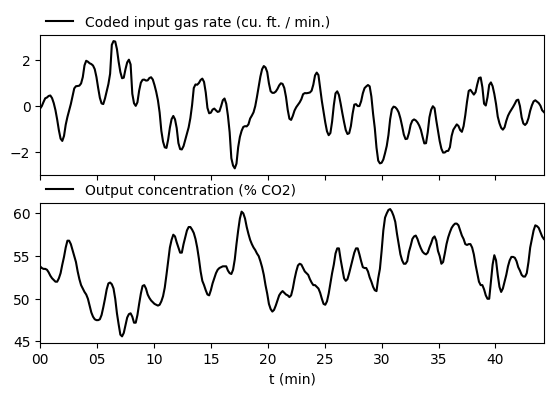

In [2]:
seriesj_data = pd.read_csv("SeriesJ.csv", index_col=0, parse_dates=True)
X = seriesj_data.iloc[:, 0]
Y = seriesj_data.iloc[:, 1]
f, ax = plt.subplots(2, 1, sharex=True, figsize=(6.5, 4))
ax[0].plot(X.index, X.values, label=X.name, color="k")
ax[0].legend(loc=(0, 1), frameon=False)
ax[1].plot(Y.index, Y.values, label=Y.name, color="k")
ax[1].legend(loc=(0, 1), frameon=False)
ax[1].set_xlabel("t (min)")
ax[1].xaxis.set_major_locator(mpl.dates.MinuteLocator(interval=5))
ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter("%M"))
ax[1].set_xlim(X.index[0], X.index[-1])

# Cross correlation and autocorrelation

Text(0.5, 0, 'Lag')

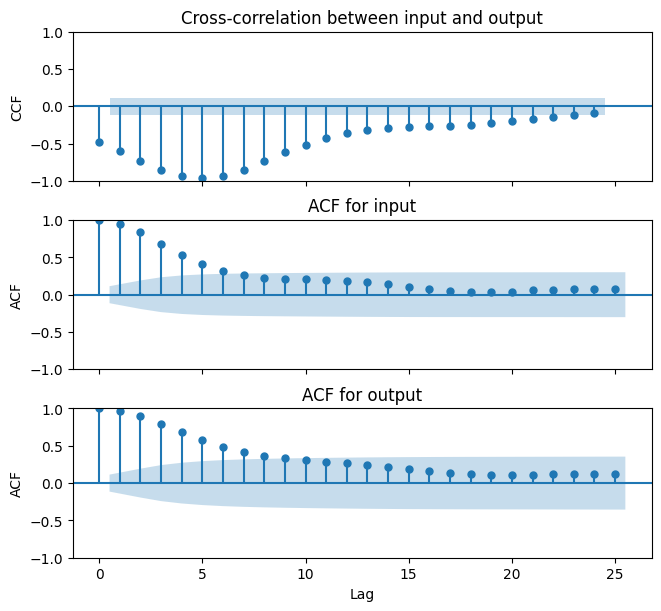

In [3]:
f, ax = plt.subplots(3, 1, sharex=True, figsize=(6.5, 6), constrained_layout=True)
lags = 25
ccf_xy = ppcc.ccf(Y, X, alpha=0.05, nlags=lags)
acf_x, acf_x_ci = acf(X, alpha=0.05, nlags=lags)
acf_X = pd.DataFrame({"acf": acf_x, "ci_low": acf_x_ci[:, 0], "ci_upp": acf_x_ci[:, 1]})
acf_y, acf_y_ci = acf(Y, alpha=0.05, nlags=lags)
acf_Y = pd.DataFrame({"acf": acf_y, "ci_low": acf_y_ci[:, 0], "ci_upp": acf_y_ci[:, 1]})

plot_corr(ccf_xy, ax=ax[0])
ax[0].set_ylabel("CCF")
ax[0].set_title("Cross-correlation between input and output")
plot_corr(acf_X, ax=ax[1])
ax[1].set_ylabel("ACF")
ax[1].set_title("ACF for input")
plot_corr(acf_Y, ax=ax[2])
ax[2].set_ylabel("ACF")
ax[2].set_title("ACF for output")
ax[2].set_xlabel("Lag")

# Prewhitening

Two options are provided for the autoregressive model that is fitted for prewhitening the input series: ARIMA(p, 0, 0) and AR(p) (Autoreg). The ARIMA model is slightly more accurate but much slower for a large number of lags. The difference with the Autoreg model is very small as is shown below.

In [4]:
p = 4  # order
Xpw_arima, Ypw_arima = ppcc.prewhiten(X, Y, ar=p, arima=True)
Xpw_autoreg, Ypw_autoreg = ppcc.prewhiten(X, Y, ar=p, arima=False)

ccf_arima = ppcc.ccf(Ypw_arima, Xpw_arima, alpha=0.05, nlags=lags)
ccf_autoreg = ppcc.ccf(Ypw_autoreg, Xpw_autoreg, alpha=0.05, nlags=lags)

(-0.5, 0.15)

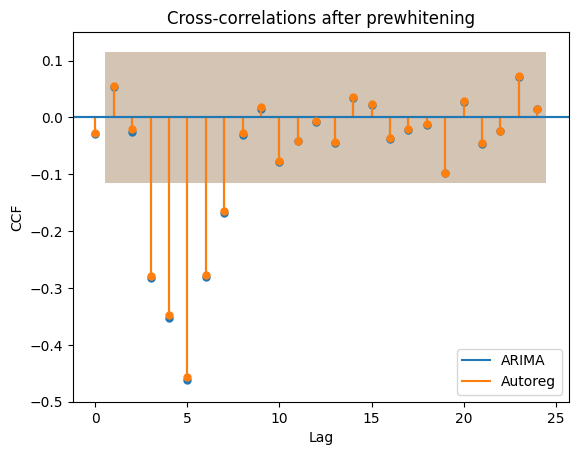

In [5]:
f, ax = plt.subplots()
plot_corr(ccf_arima, ax, dict(color="C0"))
plot_corr(ccf_autoreg, ax, dict(color="C1"))
ax.set_title("Cross-correlations after prewhitening")
ax.set_xlabel("Lag")
ax.set_ylabel("CCF")
ax.plot([], [], color="C0", label="ARIMA")
ax.plot([], [], color="C1", label="Autoreg")
ax.legend()
ax.set_ylim(-0.5, 0.15)

# Impulse response function

Text(0, 0.5, 'Scaled CCF')

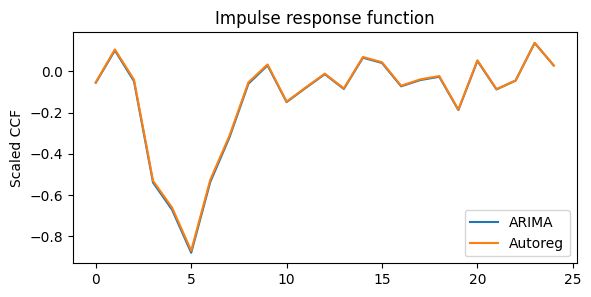

In [6]:
vk_arima = Ypw_arima.std() / Xpw_arima.std() * ccf_arima.iloc[:, 0]
vk_autoreg = Ypw_autoreg.std() / Xpw_autoreg.std() * ccf_autoreg.iloc[:, 0]

f, ax = plt.subplots(figsize=(6.5, 3))
ax.plot(vk_arima.index, vk_arima.values, label="ARIMA")
ax.plot(vk_autoreg.index, vk_autoreg.values, label="Autoreg")
ax.legend()
ax.set_title("Impulse response function")
ax.set_ylabel("Scaled CCF")